The AdjointAdvectionDiffusionModel seeks to infer the forcing functon of a linear second order differential equation of the form:

\begin{equation}
\frac{\partial u}{\partial t} + p_1\cdot\nabla u -\nabla \cdot (p_2 \nabla u)=\zeta \mbox{ in } \mathcal{X}\times [0,T]
\end{equation}
with initial conditions:

\begin{equation}
g(u(0),p)=u(0)=0
\end{equation}
and
\begin{equation}
k(u_x,u_y,p)=\nabla_{n}u=0
\end{equation}
on the boundary.

The forcing function, $\zeta$ is approximated using Random Fourier Features so that

\begin{equation}
\zeta(x,y,t)\sim \sum_{i=1}^{M}\phi_i(x,y,t)z_i
\end{equation}

$\zeta$ is then inferred using the adjoint method as in Gahungu et al. (2022).

Additionally, we seek the gradient of some cost function $F=\int_0^T\int_0^X\int_0^Yf(u,p,x,y,t)dydxdt$ (which measures the quality of our inference) with respect to the parameters $p={(p_{11},p_{12},p_2})$. To calculate this we follow the methods described in Andrew Bradley's adjoint tutorial (Bradley, 2009). 

First we set 
\begin{equation}
h(u,u_t,u_x,u_y,u_{xx},u_{yy},p,x,y,t) = \frac{\partial u}{\partial t} + p_1\cdot\nabla u -\nabla \cdot (p_2 \nabla u)-\zeta
\end{equation}
so that $h(u,u_t,u_x,u_y,u_{xx},u_{yy},p,x,y,t)=0$.
subject to $g$ and $k$. 

We establish the lagrangian:

\begin{equation}
   L =\int_0^T f(u,p,x,y,t)+ \lambda^T(h(u,u_t,u_x,u_y,u_{xx},u_{yy},p,x,y,t)) dt + \mu^Tg(s(0),p)+\nu^Tk(k(u_x,u_y,p),p) 
\end{equation}

Taking the total derivative with respect to p, integrating by parts and collecting terms (and those that are zero in our specific case) gives
\begin{equation}
d_mL=\int_0^T\int_0^X\int_0^Y\lambda^T\delta_phdydxdt 
\end{equation}
subject to
\begin{equation}
\delta_s f - \frac{\partial \lambda^T}{\partial t} - p_1\cdot\nabla \lambda^T -\nabla \cdot (p_2 \nabla \lambda^T)=0
\end{equation}

where 
\begin{equation}
\delta_ph = \left(\frac{\delta u}{\delta x},\frac{\delta u}{\delta y},-\frac{\delta^2 u}{\delta x^2}-\frac{\delta^2 u}{\delta y^2}\right).
\end{equation}

We choose the cost function 
\begin{equation}
F =\int_0^T\int_0^X\int_0^Y f(s,p,x,y,t)dt = \int^T_0\frac{1}{M}\sum_{i=0}^M (s(t)-z(t))^2\delta(y-y_i)\delta(x-x_i)\delta(t-t_i)dydxdt,
\end{equation}
where
\begin{equation}
z(t)=\begin{cases}
z_i \ \mathrm{ if } \ t=t_i,x=x_i,y=y_i \\ 0 \ \mathrm{ o.w.}
\end{cases}
\end{equation}
Here, $z_i$ are our observations. 

In [77]:
help(PDEModel.computeSourceFromPhi())

TypeError: computeSourceFromPhi() missing 2 required positional arguments: 'self' and 'z'

# Import Modules

In [19]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP

from advectionGP.models import AdjointAdvectionDiffusionModel as PDEModel

from advectionGP.wind import WindSimple#Wind model


from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt

# Establish sensor array and generate synthetic data

In [46]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,9,10) # lower time
xloc=np.linspace(1,9,5) # x locations
yloc=np.linspace(1,9,5) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+0.1 # upper time

sensors = FixedSensorModel(X,0.1) # establish sensor model arguments are sensor locations and spatial averaging

In [47]:
k_0 = 0.001 #Diffusion
R=0.1
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0,0],[10,10,10])# corners of the grid - in units of space
k = EQ(2, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [50,50,50] # grid size for time, x and y


u1 = 0.001
u2 = 0.001
windmodel=WindSimple(u1,u2) # establish fixed wind model
m = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #initiate PDE model to build concentration

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source

sourceGT=(m.computeSourceFromPhi(z))# Compute source

#sourceGT = np.zeros(m.resolution)
#sourceGT[:,20:30,20:30]=10

In [48]:
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations(addNoise=True) # Compute observations with noise uses m.sensormodel for observation locations

In [26]:
N_feat =1000 #Number of features used to infer the source
k1 = EQ(2, 2.0) 
k2 = EQ(2, 2.0) 

mPDE = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k1,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference
regressPDE = mPDE.computeModelRegressors() # Compute regressor matrix
meanZPDE, covZPDE = mPDE.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourceInfer = mPDE.computeSourceFromPhi(meanZPDE) # Generates estimated source using inferred distributio
concInfer = mPDE.computeConcentration(sourceInfer)
yOut = mPDE.computeObservations()

Calculating Adjoints...
249/250 
Calculating Phis...
999/1000 


# Functions to calculate cost $f$ using hill function approximation

In [49]:
def dcost(obs,X,conc,model): # cost derivative 
    c=np.zeros(model.resolution)
    M=len(obs)
    eps=0.1
    for i,loc in enumerate(X[:,(0,2,3)]):
        c[tuple(model.getGridCoord(loc))] = 2*(conc[tuple(model.getGridCoord(loc))]-obs[i])*(1/M)
    return c

def cost(obs,X,conc,model): # cost
    c=np.zeros(model.resolution)
    M=len(obs)
    eps=0.1
    for i,loc in enumerate(X[:,(0,2,3)]):
        c[tuple(model.getGridCoord(loc))] = ((conc[tuple(model.getGridCoord(loc))]-obs[i])**2)*(1/M)
    return c

# Function to calculate adjoint equation

In [30]:
def computeGradientAdjoint(dcost,model):
        """
        Runs the backward PDE (adjoint problem)
        Gets called for an observation instance (H).
        (v is the result of the adjoint operation)
        """
        dt,dx,dy,dx2,dy2,Nt,Nx,Ny = model.getGridStepSize()

        v=np.zeros(((Nt,Nx,Ny)))
        v[-1,:,:]=0.0
        u=model.u
        k_0=model.k_0
        for i in range(1,Nt): #TODO might be better to rewrite as range(Nt-1,1,-1)...
    #Corner BCs   
            v[-i-1,0,0]=v[-i,0,0]+dt*(-dcost[-i,0,0]) # BC at x=0, y=0
            v[-i-1,Nx-1,Ny-1]=v[-i,Nx-1,Ny-1]+dt*(-dcost[-i,Nx-1,Ny-1]) # BC at x=xmax, y=ymax
            v[-i-1,0,Ny-1]=v[-i,0,Ny-1]+dt*( -dcost[-i,0,Ny-1]) # BC at x=0, y=ymax
            v[-i-1,Nx-1,0]=v[-i,Nx-1,0]+dt*( -dcost[-i,Nx-1,0]) # BC at x=xmax, y=0


    #Edge BCs   
            v[-i-1,Nx-1,1:Ny-1]=v[-i,Nx-1,1:Ny-1]+dt*(-dcost[-i,Nx-1,1:Ny-1] +u[1][-i,Nx-1,1:Ny-1]*(v[-i,Nx-1,2:Ny]-v[-i,Nx-1,0:Ny-2] )/(2*dy) +k_0*(v[-i,Nx-1,2:Ny]-2*v[-i,Nx-1,1:Ny-1]+v[-i,Nx-1,0:Ny-2])/dy2) # BC at x=xmax        
            v[-i-1,0,1:Ny-1]=v[-i,0,1:Ny-1]+dt*(-dcost[-i,0,1:Ny-1]+u[1][-i,0,1:Ny-1]*(v[-i,0,2:Ny]-v[-i,0,0:Ny-2] )/(2*dy) +k_0*(v[-i,0,2:Ny]-2*v[-i,0,1:Ny-1]+v[-i,0,0:Ny-2])/dy2 ) # BC at x=0

            v[-i-1,1:Nx-1,0]=v[-i,1:Nx-1,0]+dt*(   -dcost[-i,1:Nx-1,0]+u[0][-i,1:Nx-1,0]*(v[-i,2:Nx,0]-v[-i,0:Nx-2,0] )/(2*dx) +k_0*(v[-i,2:Nx,0]-2*v[-i,1:Nx-1,0]+v[-i,0:Nx-2,0])/dx2  )# BC at y=0
            v[-i-1,1:Nx-1,Ny-1]=v[-i,1:Nx-1,Ny-1]+dt*(-dcost[-i,1:Nx-1,Ny-1]+u[0][-i,1:Nx-1,Ny-1]*(v[-i,2:Nx,Ny-1]-v[-i,0:Nx-2,Ny-1] )/(2*dx)+k_0*(v[-i,2:Nx,Ny-1]-2*v[i,1:Nx-1,Ny-1]+v[-i,0:Nx-2,Ny-1])/dx2) # BC at y=ymax

    #Internal calculation (not on the boundary)
            v[-i-1,1:Nx-1,1:Ny-1]=v[-i,1:Nx-1,1:Ny-1] +dt*( -dcost[-i,1:Nx-1,1:Ny-1]+u[0][-i,1:Nx-1,1:Ny-1]*(v[-i,2:Nx,1:Ny-1]-v[-i,0:Nx-2,1:Ny-1])/(2*dx) +u[1][-i,1:Nx-1,1:Ny-1]*(v[-i,1:Nx-1,2:Ny]-v[-i,1:Nx-1,0:Ny-2] )/(2*dy)+k_0*(v[-i,2:Nx,1:Ny-1]-2*v[-i,1:Nx-1,1:Ny-1]  +v[-i,0:Nx-2,1:Ny-1])/dx2+k_0*(v[-i,1:Nx-1,2:Ny]-2*v[-i,1:Nx-1,1:Ny-1]  +v[-i,1:Nx-1,0:Ny-2])/dy2 )
        return v

# Function to calculate the Lagrangian derivative, the cost and the derivative of the cost for a given $p$

In [32]:
def d_mL(u1,u2,k_0,model,obs,tloc,source):
    
    #set new model parameters
    model.windmodel=WindSimple(u1,u2)
    model.u=model.windmodel.getu(model)
    model.k_0=k_0
    
    #calculate useful scalars
    dt,dx,dy,dx2,dy2,Nt,Nx,Ny = model.getGridStepSize()
    
    #calculate new source (not currently used)
    #regressPDE = mPDE.computeModelRegressors() # Compute regressor matrix
    #meanZPDE, covZPDE = mPDE.computeZDistribution(yTrain) # Infers z vector mean and covariance
    #source = mPDE.computeSourceFromPhi(meanZPDE) # Generates estimated source using inferred distributio
    
    #calculate concentration and dpH
    conc=model.computeConcentration(source)
    dudx=np.gradient(conc,dx,axis=1)
    dudy=np.gradient(conc,dy,axis=2)
    d2udx2 = np.gradient(dudx,dx,axis=1)
    d2udy2 = np.gradient(dudy,dy,axis=2)

    dmH=np.array([dudx,dudy,-d2udx2-d2udy2])
    
    #calculate cost and cost derivative
    dc=dcost(obs,tloc,conc,model)
    c=cost(obs,tloc,conc,model)
    #print(np.sum((c/2)**2))
    L_m=np.zeros(3)
    for i, dmHi in enumerate(dmH):
        integrand = computeGradientAdjoint(dc,model)*dmHi
    #L_m = np.trapz(integrand,dx=dt)
        L_m[i] = np.sum(integrand)*dt*dx*dy
    return L_m, dc,c

# Naive gradient descent (output used to test gradient calculation)


In [76]:
reps = 5000
p=np.zeros((3,reps)) # parameter vals
d=np.zeros((3,reps-1)) # derivative
dTest=np.zeros((3,reps-1)) # derivative test forward difference
dTest2=np.zeros((3,reps-1)) # derivative test central difference 
Fc=np.zeros((3,reps-1)) # cost
p[:,0]=np.array([u1,u2,k_0])+np.random.normal(0,0.001,3)
eps2=1e-8
for i in range(reps-1):
    [u11,u21,k_01] = p[:,i]
    print(i)
    dmL, dc,c=d_mL(u11,u21,k_01,mPDE,yTrain,X,sourceInfer)
    d[:,i]=dmL
    p[:,i+1]=p[:,i]-0.00001*dmL
    Fc[:,i] = np.sum(c)*dt*dx*dy
    dmL2, dc2,c2=d_mL(u11+eps2,u21,k_01,mPDE,yTrain,X,sourceInfer)
    dmL3, dc3,c3=d_mL(u11,u21+eps2,k_01,mPDE,yTrain,X,sourceInfer)
    dmL4, dc4,c4=d_mL(u11,u21,k_01+eps2,mPDE,yTrain,X,sourceInfer)
    dmL5, dc5,c5=d_mL(u11-eps2,u21,k_01,mPDE,yTrain,X,sourceInfer)
    dmL6, dc6,c6=d_mL(u11,u21-eps2,k_01,mPDE,yTrain,X,sourceInfer)
    dmL7, dc7,c7=d_mL(u11,u21,k_01-eps2,mPDE,yTrain,X,sourceInfer)
    
    dTest[:,i] = (np.array((np.sum((c2))*dt*dx*dy-np.sum((c5))*dt*dx*dy,np.sum((c3))*dt*dx*dy-np.sum((c6))*dt*dx*dy,np.sum((c4))*dt*dx*dy-np.sum((c7))*dt*dx*dy)))/(2*eps2)
    dTest2[:,i] = ((np.sum((c2))*dt*dx*dy,np.sum((c3))*dt*dx*dy,np.sum(c4)*dt*dx*dy)-(np.sum(c)*dt*dx*dy))/(eps2)

0
1
2


KeyboardInterrupt: 

In [70]:
np.random.normal(0,0.0,3)

array([0., 0., 0.])

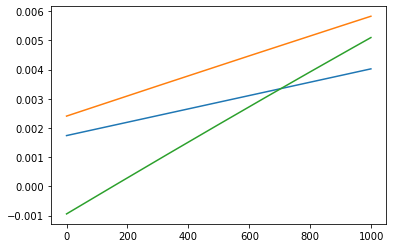

In [71]:
plt.plot(p.T)

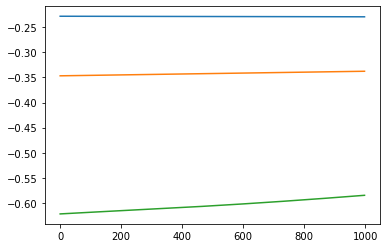

In [72]:
plt.plot(d.T)

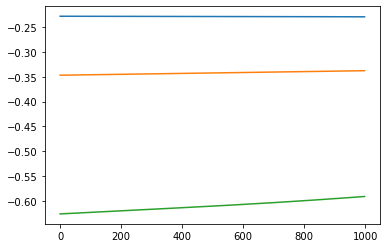

In [73]:
plt.plot(dTest.T)

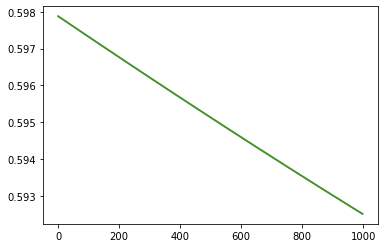

In [74]:
plt.plot(Fc.T)

### Functions for cost and derivative for use with scipy optimiser


In [75]:
def FullCost(x,model,obs,tloc,source):
    #model.k_0=x[2]
    model.windmodel=WindSimple(x[0],x[1])
    model.u=model.windmodel.getu(model)
    model.k_0=x[2]
    dt,dx,dy,dx2,dy2,Nt,Nx,Ny = model.getGridStepSize()
    conc=model.computeConcentration(source)

    c1=cost(obs,tloc,conc,model)
    
    c = np.sum(c1)*dt*dx*dy
    
    return c

In [64]:
def FullDeriv(x,model,obs,tloc,source):
    model.windmodel=WindSimple(x[0],x[1])
    model.u=model.windmodel.getu(model)
    model.k_0=x[2]
    dt,dx,dy,dx2,dy2,Nt,Nx,Ny = model.getGridStepSize()
    conc=model.computeConcentration(source)
    dudx=np.gradient(conc,dx,axis=1)
    dudy=np.gradient(conc,dy,axis=2)
    d2udx2 = np.gradient(dudx,dx,axis=1)
    d2udy2 = np.gradient(dudy,dy,axis=2)

    dmH=np.array([dudx,dudy,-d2udx2-d2udy2])
    
    dc=dcost(obs,tloc,conc,model)
    c=cost(obs,tloc,conc,model)
    #print(np.sum((c/2)**2))

    #L_m = np.trapz(integrand,dx=dt)
    L_m=np.zeros(3)
    for i, dmHi in enumerate(dmH):
        integrand = computeGradientAdjoint(dc,model)*dmHi
    #L_m = np.trapz(integrand,dx=dt)
        L_m[i] = np.sum(integrand)*dt*dx*dy
    return L_m

In [65]:
from scipy.optimize import minimize

In [66]:
x0 = [0.011,0.011,0.011]

In [67]:
result = minimize(FullCost, x0, method='bfgs', jac=FullDeriv,args=(mPDE,yTrain,X,sourceInfer),options={'disp': True},tol=1e-4)

         Current function value: 0.503676
         Iterations: 4
         Function evaluations: 35
         Gradient evaluations: 24


In [68]:
result

      fun: 0.5036756639086136
 hess_inv: array([[ 1.94094984,  0.56478018, -0.50923902],
       [ 0.56478018,  0.71395237, -0.23032326],
       [-0.50923902, -0.23032326,  0.15185251]])
      jac: array([-0.204485  , -0.10039503, -0.2925112 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 35
      nit: 4
     njev: 24
   status: 2
  success: False
        x: array([0.22196969, 0.13787189, 0.02872982])

In [50]:
x=result.x
mInfer=mPDE
#mInfer = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k1,sensormodel=sensors,k_0=-1,u=x[0],eta=x[1]) #Initiate new model for inference
for i in range(50):
    mInfer.windmodel=WindSimple(x[0],x[1])
    mInfer.u=mInfer.windmodel.getu(mInfer)
    mInfer.k_0=x[2]
    mInfer.computeModelRegressors() # Compute regressor matrix 
    meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
    sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
    concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source
    result = minimize(FullCost, x, method='BFGS', jac=FullDeriv,args=(mInfer,yTrain,X,sourceInfer),options={'disp': True},tol=1e-8)
    x = result.x
    print(result.x)

Calculating Adjoints...
74/75 
Calculating Phis...
999/1000 
         Current function value: 0.018752
         Iterations: 7
         Function evaluations: 76
         Gradient evaluations: 59
[0.06162126 0.03910621 0.02107232]
Calculating Adjoints...
74/75 
Calculating Phis...
999/1000 
         Current function value: 0.051620
         Iterations: 6
         Function evaluations: 64
         Gradient evaluations: 46
[0.08649803 0.0447028  0.04447528]
Calculating Adjoints...
74/75 
Calculating Phis...
999/1000 
         Current function value: 0.134327
         Iterations: 1
         Function evaluations: 27
         Gradient evaluations: 7
[0.08747289 0.0433663  0.05262178]
Calculating Adjoints...
74/75 
Calculating Phis...
999/1000 
         Current function value: 0.166642
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 3
[0.08747289 0.0433663  0.05262178]
Calculating Adjoints...
74/75 
Calculating Phis...
999/1000 
         Current function

KeyboardInterrupt: 